# Ant Colony Optimization - Student task

### Context description:
You might have heard of the 9€ ticket that should be available in Germany from June until August. With this ticket, you are able to take regional trains and busses within Germany for 9€ per month. You're taking the chance and plan a city trip through Germany. Since you don't want to spend too much time in the trains to have more time in the cities, you want to optimize your traveling route. 

Specifically, you want to visit the following cities: 

**Osnabrück, Münster, Köln, München, Hamburg, Berlin, Hannover, Karlsruhe, Leipzig, Düsseldorf,Kassel, Cottbus, Bremen, Nürnberg, Saarbrücken**

For task simplicity, we assume that:
1. there are direct connections between all cities.
2. the distance between the cities is a valid indicator for the required travel time.

Of course, both assumptions might not be true in the real world.

### Task 1: The Ant System
In the presentation, you have seen how Ant System can be used to solve the TSP. We want you to implement this yourself to solve the task decribed above. We provide you with the basic code structure, which includes the classes ```Ant``` and ```AntColony```. You will have to add your implementation marked with *## add your code here*. We also provide brief descriptions of what should be implemented at those positions. For the relevant formulas, we would like to refer to the presentation slides regarding **Ant System**.

Our implementation further makes use of the classes ```View```, ```Node```, ```Edge```, ```Graph```, ```Germany```. You can view those as helper classes contained in the file ```graph.py```. You do not have to do anything in that file.

In [1]:
from itertools import count
from graph import *
from time import time
import random

### Task 1.1 Finish the Ant class
For the Ant class, there are three function that you need to implement: ```reset```, ```step```, and ```transitions```. In their docstrings, you can see what is supposed to happen in those functions.

In [7]:
class Ant:
    def __init__(self, graph, neighbors, valid, alpha=1, beta=1, termination=lambda self: bool(self.nodes)):
        """
        An ant is supposed to travel within a graph, visiting all nodes exactly once.
        :param graph: graph in which the ant is traveling
        :param neighbors: function that returns the neighbours of the node the ant currently is on
        :param valid: True once an ant has finished its solution
        :param alpha: importance of pheromone quantity
        :param beta: importance of heuristic information
        :param termination:
        """
        self.graph = graph
        self.neighbors = lambda n: neighbors(self, n)
        self.valid = lambda: valid(self)
        self.alpha = alpha
        self.beta = beta
        self.termination = lambda: termination(self)
        self.reset()

    def __contains__(self, other):
        """
        Allows to test, whether the input is contained in either the nodes or edges within the current path.
        :param other: input can be an edge or node or another object
        :return: True if the inpu already is in the path (either as a node or edge), False otherwise
        """
        if isinstance(other, Node):
            return other in self.path_nodes
        elif isinstance(other, Edge):
            return other in self.path_edges
        else:
            return False

    def reset(self):
        """
        Resets the current 'status' of an ant, i.e. ant is initialized on a random node within the graph and has not
        travelled yet.
        """
        ## add your code here
        ## TASK: Implement the class variables self.travel_dist (int), self.node (Node), self.path_nodes (list), and 
        ## self.path_edges (list)
        
        self.travel_dist = 0  # distance travelled
        self.node = random.choice(self.graph)  # current node on which the ant resides
        self.path_nodes = [self.node]  # current path of ant described through nodes
        self.path_edges = []  # current path of the ant described through edges

    def step(self):
        """
        Performs the next step of the ant, choosing the next node based on transition probabilities and adds the node
        and edges to the current path information.
        :return: True if a next step was performed, False otherwise
        """
        ## add your code here
        ## HINT: You have to use the transitions function to determine the next node that is to be visited
        
        # Get the transition options and probabilities
        self.nodes, probabilities = self.transitions()
        # Stop if no nodes are to be visited anymore
        if not self.termination(): return False
        # Select a new node based on the provided probabilities and save the new node and the respective edge in the
        # path of the ant
        node = random.choices(self.nodes, weights=probabilities)[0]
        edge = self.graph[self.node, node]
        self.path_nodes.append(node)
        self.path_edges.append(edge)
        self.travel_dist += edge.value  # Update the total travelled distance of this ant
        self.node = node  # Update the current node
        return True

    def transitions(self):
        """
        Performs the calculations to receive information which nodes can be visited next with which probabilities.
        :return nodes, probabilities: return the nodes and their respective probabilities that the ant travels to next
        """
        ## add your code here
        ## HINT: You could need the function self.neighbours()
        
        # For all nodes the current node is connected to, get the heuristic information and pheromone value for the
        # respective edge
        nodes, heuristic, pheromone = [], [], []
        for node in self.node:
            if self.neighbors(node):
                edge = self.graph[self.node, node]
                nodes.append(node)
                heuristic.append(edge.heuristic)
                pheromone.append(edge.pheromone)
                
        # Perform the calculations to receive the probabilities to determine the next node
        eta = np.array(heuristic)
        tau = np.array(pheromone)
        phi = tau ** self.alpha * eta ** self.beta
        return nodes, phi/np.sum(phi)

### Task 1.2 Finish the AntColony class

For this task, you have to implement the ```update``` function. This is where the pheromone trails are updated for the next iteration. You also have to set the heuristic information in ```init```.

In [71]:
class AntColony:
    def __init__(self, n_ants, graph, rho=0.1, alpha=1, beta=1,
                 neighbors=lambda a, n: len(a.graph) > len(a.path_nodes) and n not in a.path_nodes 
                                     or len(a.graph) == len(a.path_nodes) and n == a.path_edges[0].source,
                 valid=lambda a: len(a.path_nodes) == len(a.graph) + 1, elitist=False):
        """
        An ant colony consists of a given number of ants, a graph in which the ants travel and parameter information on
        the algorithm: rho, alpha, and beta.
        :param n_ants: Number of ants within the colony
        :param graph: Graph with a problem to solve
        :param rho: Evaporation rate
        :param alpha: importance of pheromone quantity
        :param beta: importance of heuristic information
        :param neighbors: a function how the neighbours of a node are defined
        :param valid: a function that determines if ants have found a valid solution
        """
        self.n_ants = n_ants
        self.graph = graph
        self.rho = rho
        self.alpha = alpha
        self.beta = beta
        self.graph.edges.heuristic = 1 / (self.graph.edges.value + 0.00001) ## add your code here - exchange None with the correct heuristics
        self.elitist = elitist
        self.ants = [Ant(self.graph, neighbors, valid, alpha, beta) for _ in range(n_ants)]
        self.node = random.choice(graph)
        self.graph.edges.pheromone = 1.0

    def __call__(self, N=None):
        """
        Executes the ant colony optimization algorithm.
        :param N: number of iterations
        :param visualization: whether intermediate results should be visualized
        :return: # TODO
        """
        start = time()
        iterator = count() if N is None else range(N)
        self.min_length = float('inf')
        self.min_path = None

        for _ in iterator:
            # Reset all ants at the beginning of each iteration
            for ant in self:
                ant.reset()
                
            # Let ants create their solution and update pheromones based on those
            self.construct()
            self.daemon()
            self.update()
            
        end = time()
        print(f"RUN TIME: {round(end - start, 1)} sec")
        return self.min_path, self.min_length, self.graph.edges.pheromone

    def __iter__(self):
        """
        Allows to iterate over the ants in the colony
        :return: ---
        """
        for ant in self.ants:
            yield ant

    def construct(self, visualization=False):
        """
        Constructs ant solutions as long as all ants can take a further step.
        :param visualization: whether intermediate results should be visualized
        :return: ---
        """
        while any(ant.step() for ant in self):
            if visualization:
                self.visualize()

    def daemon(self):
        """
        (Optionally) Daemon actions needed to print the information
        :return: ---
        """
        min_path, min_edges, min_length = min(((ant.path_nodes, ant.path_edges, ant.travel_dist)
            for ant in self if ant.valid()), key=lambda t: t[2])
        #min_ant = min(self, key=lambda t: t.travel_dist)
        if self.min_length > min_length:
            self.min_length = min_length
            self.min_path = list(min_path)
            self.min_edges = list(min_edges)

    def update(self, F=lambda x: 1/x):
        """
        Updates pheromone trails after all ants have finished their travels during one iteration.
        :param F: function to create the multiplicative inverse of a given number
        :return: ---
        """
        ### add your code here
        
        # Get all paths that all ants have taken
        ants = [ant for ant in self if ant.valid()]
        
        # Update the pheromones on all edges based on the previous pheromones weighted through the evaporation rate, and
        # the newly added pheromones
        for edge in set(edge for ant in ants for edge in ant.path_edges):
            S = sum(F(ant.travel_dist) for ant in ants if edge in ant)
            edge.pheromone = (1 - self.rho) * edge.pheromone + S
        
        if self.elitist:
            epsilon = 5000
            for edge in set(self.min_edges):
                edge.pheromone += F(self.min_length) * epsilon

We added the class ```Germany``` to this notebook so you can take a look at it how things are visualized in the end. If you are not interested in this, feel free to ignore the following code block.

In [67]:
class Germany(TSP):
    def __init__(self, cities):
        cities = cities
        coordinates = list(cities.values())
        super().__init__(coordinates=coordinates)


    def visualize(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Route')
        if 'pheromone' in self._edge_values.keys():
            pheromone = self.edges.pheromone
        else:
            raise Warning(f"Edges of the graph must have the attribute 'pheromone'. Graph only got {', '.join(self._edge_values.keys())}")
        
        # Get the coordinates of all nodes
        coords = np.array([node.coordinates for node in self])
        
        # Get min and max pheromones to normalize later
        max_phero = np.max(pheromone[pheromone != 1.0])
        min_phero = np.min(pheromone[pheromone != 1.0])
        
        for n_i in self:
            for n_j in self:
                # Draw the connection of the two nodes based on the pheromone concentration
                if not n_i == n_j:
                    x_values = [n_i.coordinates[0], n_j.coordinates[0]]
                    y_values = [n_i.coordinates[1], n_j.coordinates[1]]
                    
                    # Normalize pheromones for better visibility
                    normed_pheromone = (pheromone[n_i.name, n_j.name] - min_phero) / (max_phero - min_phero)
                    
                    # Draw the connection based on determined normed pheromone level
                    ax.plot(x_values, y_values, '-', color=[0, 0, 0, normed_pheromone])
        
        # Mark all cities with a dot
        ax.scatter(coords[:, 0], coords[:, 1])
        ax.imshow(plt.imread("osm_germany.png"))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

You can now execute the following code. If everything works, after some time there should be a card displayed with the cities marked and connected. The darker the connection between two cities, the higher was the pheromone on that edge in the last iteration.

In [68]:
# Feel free to add or delete cities to this dictionary. The coordinates are based on the image 'osm_germany.png'.
cities = {'Osnabrück': (235, 234),
          'Hamburg': (324, 137),
          'Hanover': (312, 226),
          'Frankfurt': (264, 391),
          'Munich': (396, 528),
          'Berlin': (478, 215),
          'Leipzig': (432, 302),
          'Düsseldorf': (175, 310)}

# Cities you could add:
#           'Kassel': (302, 305),
#           'Cottbus': (521, 274), 
#           'Bremen': (270, 173),
#           'Karlsruhe': (251, 469),
#           'Nürnberg': (373, 437),
#           'Saarbrücken': (187, 452)\

RUN TIME: 3.9 sec


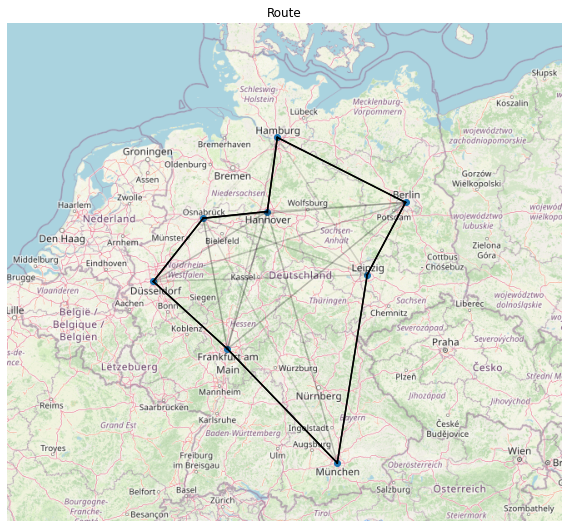

In [69]:
G = Germany(cities)
C = AntColony(20, G, alpha=3.0, beta=3.0, rho=0.1, elitist=False)
ant_path, ant_length, pheromone = C(40)
G.visualize()

### Task 2: Implement the Elitist Ant System

As mentioned in the presentation, **Elistist Ant System** is an improvement of **Ant System**. The idea is, that the ant that took the best-so-far tour can add additional pheromone to the route.

Your task now is to revisit the ```AntColony``` class and change the ```update``` function accordingly. The class variable self.elitist might help you differentiating **Ant System** and **Elitist Ant System** in this function.

HINT 1: Take a closer look at the ```daemon``` function and figure out how you can make use of what happens there.

HINT 2: You can vary how strongly the elitist ant update is weighted.

RUN TIME: 3.4 sec


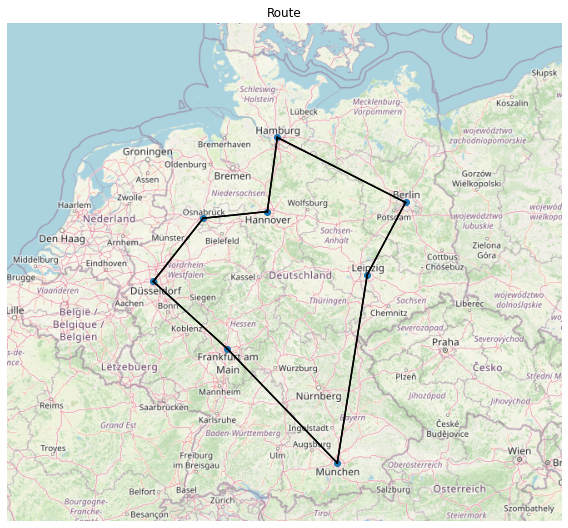

In [70]:
G = Germany(cities)
C = AntColony(20, G, alpha=3.0, beta=3.0, rho=0.1, elitist=True)
ant_path, ant_length, pheromone = C(40)
G.visualize()

### Task 3:
1. Report the results of Ant System and Elitist Ant System (write down some findings, and e.g. show the produced images)
2. Try out different parameter values: What happens if you change alpha, beta, the evaporation rate *rho*, the number of ants, and the number of iterations?
3. (Optionally) With the code below (```G.route()```), you can run a search algorithm that finds the shortest path in a graph. You can compare for different numbers of cities, how long it takes to run this search and how long it takes for **AntSystem** to find a good solution.

In [ ]:
import time

# Initialize a graph with cities
cities2 = {'Osnabrück': (235, 234),
           'Hamburg': (324, 137),
           'Hanover': (312, 226),
           'Frankfurt': (264, 391),
           'Munich': (396, 528),
           'Berlin': (478, 215),
           'Leipzig': (432, 302),
           'Düsseldorf': (175, 310)}
G = Germany(cities2)

# Time how long the search takes
start = time.time()
G.route()
print(f'Finished after {time.time() - start} seconds.' )